In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import csv
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import joblib
import matplotlib.pyplot as plt
import math


# MPPI-generated dataset

In [ ]:
# Data processing with limit filters
filename_input = '/content/states_from_mppi.csv'

input = []
with open(filename_input, mode='r', newline='') as file:
    reader = csv.reader(file)
    headers = next(reader)
    for row in reader:
        input.append([float(r) for r in row])
inputs = [input[i][4:-3] for i in range(len(input))]
quality = [input[i][-3:] for i in range(len(input))]
print(len(inputs))
print(len(inputs[0]))
print(len(quality[0]))
print(inputs[0])
print(quality[0])


18141
12
3
[5.777871131896973, 5.185089111328125, 0.07156264781951904, -2.3166010123532033e-06, -4.786302270076703e-06, 1.2341823094175197e-05, 5.419728755950928, 4.25071907043457, -0.0075306277722120285, 0.18873652815818787, -0.25466179847717285, -0.0004365821660030633]
[0.6062203049659729, 0.0, 0.0]


In [ ]:
# Data processing with limit filters
filename_input = '/content/ao_est.csv'
label = []
with open(filename_input, mode='r', newline='') as file:
    reader = csv.reader(file)
    headers = next(reader)
    for row in reader:
        label.append([float(r) for r in row])

success_labels = [label[i][-2] for i in range(len(label))]
maneuver_labels = [label[i][-1] for i in range(len(label))]
print(len(success_labels))
print(success_labels[0])

18141
5.921210886591475e-06


In [ ]:
import heapq
import numpy as np

xo = [q[1] for q in quality]
ten_largest_values = heapq.nlargest(100, xo)
print(ten_largest_values)
print(np.median(xo))
print(np.mean(xo))

[347.8937072753906, 311.1250915527344, 297.3718566894531, 281.4647216796875, 279.0978088378906, 252.55519104003906, 195.56863403320312, 188.1468505859375, 181.9153594970703, 166.5492401123047, 150.75465393066406, 139.209716796875, 138.70654296875, 134.4258270263672, 132.79295349121094, 124.02455139160156, 123.90391540527344, 116.97223663330078, 89.43507385253906, 80.06819915771484, 63.33731460571289, 62.67109298706055, 59.50260543823242, 56.250267028808594, 46.282772064208984, 43.65011215209961, 41.3482780456543, 32.07596206665039, 30.884151458740234, 30.846742630004883, 29.599044799804688, 27.236591339111328, 25.180545806884766, 24.496471405029297, 19.496564865112305, 19.354162216186523, 19.217042922973633, 19.13922119140625, 19.04962730407715, 18.92469596862793, 18.726829528808594, 18.566875457763672, 18.511306762695312, 17.984643936157227, 16.134342193603516, 15.66304874420166, 15.278175354003906, 15.143542289733887, 15.128437995910645, 15.083898544311523, 15.052336692810059, 13.684

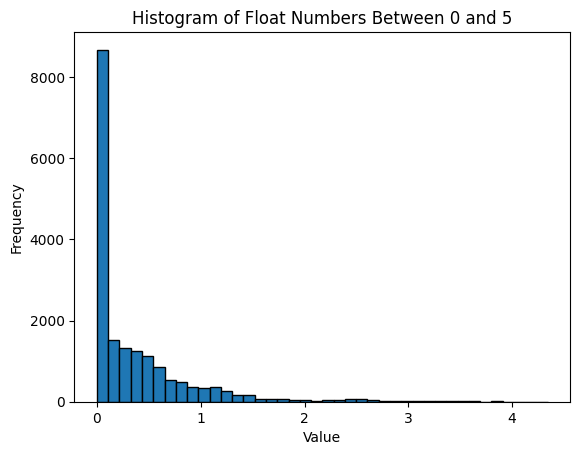

In [ ]:
# xo = [inputs[i][0] for i in range(len(inputs))]
# xo = [success_labels[i] for i in range(len(success_labels))]
xo = [q[0] for q in quality]

# Create the histogram
plt.hist(xo, bins=40, edgecolor='black')  # You can adjust the number of bins

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Float Numbers Between 0 and 5')

# Show the plot
plt.show()

# TENSORFLOW

In [ ]:
# Assuming X is your input data and y is your output data
labels = [[s,m] for s,m in zip(success_labels, maneuver_labels)]
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.2, random_state=42)

# Min-Max Scaling
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)
joblib.dump(min_max_scaler, 'scaler_minmax.pkl')

# Standardization
standard_scaler = StandardScaler()
X_train_standard = standard_scaler.fit_transform(X_train)
X_test_standard = standard_scaler.transform(X_test)

# # Normalize the data
# scaler = StandardScaler()
# X_train = scaler.fit(X_train)
# X_test = scaler.transform(X_test[:2])

In [ ]:
joblib.dump(min_max_scaler, 'scaler_minmax.pkl')


['scaler_minmax.pkl']

In [ ]:
# # Load the scaler
# scaler0 = joblib.load('my_scaler.pkl')

# # Apply the scaler to new data
# X_new_transformed = scaler0.transform(X_test[:2])
# X_new_transformed

array([[-1.63852813, -0.50929621,  0.08382842, -0.13254498, -1.53643876,
        -0.48864586,  0.00356794,  1.42156081,  0.02362815, -0.37003961],
       [-1.4017682 , -0.41107987, -0.19069578,  0.03995952, -1.37368982,
        -0.38683071,  0.00732365,  1.2256062 ,  0.1998657 ,  0.13719381]])

In [ ]:
# Build the model
hidden_layer_neurals = 64
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(hidden_layer_neurals, activation='relu', input_shape=(10,)),
    tf.keras.layers.Dense(hidden_layer_neurals, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_neurals, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_neurals, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_neurals, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
# Define your desired learning rate
learning_rate = 2e-4
adam_optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# # Train the model
model.fit(X_train_minmax, y_train, validation_split=0.15, epochs=300, batch_size=32, verbose=2)

Epoch 1/300
65/65 - 2s - loss: 0.8649 - val_loss: 0.5981 - 2s/epoch - 35ms/step
Epoch 2/300
65/65 - 0s - loss: 0.5417 - val_loss: 0.5303 - 294ms/epoch - 5ms/step
Epoch 3/300
65/65 - 0s - loss: 0.4823 - val_loss: 0.4703 - 255ms/epoch - 4ms/step
Epoch 4/300
65/65 - 0s - loss: 0.4376 - val_loss: 0.4331 - 250ms/epoch - 4ms/step
Epoch 5/300
65/65 - 0s - loss: 0.4111 - val_loss: 0.4090 - 262ms/epoch - 4ms/step
Epoch 6/300
65/65 - 0s - loss: 0.3882 - val_loss: 0.3820 - 247ms/epoch - 4ms/step
Epoch 7/300
65/65 - 0s - loss: 0.3647 - val_loss: 0.3586 - 251ms/epoch - 4ms/step
Epoch 8/300
65/65 - 0s - loss: 0.3376 - val_loss: 0.3466 - 261ms/epoch - 4ms/step
Epoch 9/300
65/65 - 0s - loss: 0.3149 - val_loss: 0.3181 - 306ms/epoch - 5ms/step
Epoch 10/300
65/65 - 0s - loss: 0.2921 - val_loss: 0.3065 - 258ms/epoch - 4ms/step
Epoch 11/300
65/65 - 0s - loss: 0.2702 - val_loss: 0.3079 - 365ms/epoch - 6ms/step
Epoch 12/300
65/65 - 0s - loss: 0.2528 - val_loss: 0.2541 - 377ms/epoch - 6ms/step
Epoch 13/300
65

In [ ]:
# Evaluate the model

test_loss = model.evaluate(X_test_minmax, y_test)

20/20 [==============================] - 0s 2ms/step - loss: 0.0998


In [ ]:

# Generate predictions
y_pred = model.predict(X_test_minmax)

# Flatten y_pred to ensure it's in the same shape as y_test
y_pred = y_pred.flatten()

# Print true and predicted values
for true, pred in zip(y_test, y_pred):
    print(f"True: {true}, Predicted: {pred}")

20/20 [==============================] - 0s 3ms/step
True: 3.0178682662762513, Predicted: 2.9539005756378174
True: 0.34011344442588587, Predicted: 0.462912380695343
True: 0.4888605092503627, Predicted: 0.46087661385536194
True: 0.5187183288106738, Predicted: 0.5197278261184692
True: 3.839619957911904, Predicted: 4.492387294769287
True: 0.5437148188748948, Predicted: 0.5917494297027588
True: 1.8904210069442406, Predicted: 1.8316186666488647
True: 0.16692362756604606, Predicted: 0.2620367109775543
True: 0.6165579585404503, Predicted: 0.6703601479530334
True: 0.4256696180779985, Predicted: 1.259719967842102
True: 0.2265400860152856, Predicted: -0.07402719557285309
True: 0.3635165964266504, Predicted: 0.457239031791687
True: 3.1286093587060138, Predicted: 3.123720645904541
True: 0.37906718659229477, Predicted: 0.37145134806632996
True: 0.5592932747010888, Predicted: 0.5612027049064636
True: 0.9191880242335625, Predicted: 1.0597026348114014
True: 0.5398662690392555, Predicted: 0.57371300458

In [ ]:
# model.save_weights('cage_metric_model.ckpt')
model.save('model_varyingGoal_cutoffLabels.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the entire model
new_model = load_model('path_to_my_model.h5')

# Use the model for inference
i = (X_test[0:1]).tolist()
print(i)
prediction = new_model.predict(i)
print(prediction)

[[-1.6385281345710567, -0.5092962134283774, 0.08382842145923423, -0.13254497591122066, -1.5364387572726412, -0.4886458616509667, 0.003567941207741127, 1.4215608118319583, 0.023628152616274812, -0.3700396101036746]]
1/1 [==============================] - 0s 234ms/step
[[1.4909074]]


# TORCH 1D Output

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
layer_size = 64

# Training loop
def train_loop(dataloader, model, loss_fn, optimizer):
    total_loss = 0
    num_batch = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / batch

def val_loop(dataloader, model, loss_fn):
    num_batch = len(dataloader)
    total_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss = loss_fn(pred, y.unsqueeze(1))
            total_loss += loss.item()
    return total_loss / num_batch

# Define the model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(12, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)


In [ ]:
# Assuming 'inputs' and 'labels' are your data
# labels = [[s,m] for s,m in zip(success_labels, maneuver_labels)]
labels = [-dis+stick+engage for dis,stick,engage in quality]
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.15, random_state=42)

# # Min-Max Scaling
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)
joblib.dump(min_max_scaler, 'scaler_minmax.pkl')

# Standardization
# standard_scaler = StandardScaler()
# X_train = standard_scaler.fit_transform(X_train)
# X_test = standard_scaler.transform(X_test)
# joblib.dump(min_max_scaler, 'scaler_standard.pkl')


['scaler_minmax.pkl']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  # 0.25 x 0.8 = 0.2

# Convert arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = NeuralNetwork()

# Define the optimizer and loss function
learning_rate = 3e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()


In [ ]:
train_losses = []
val_losses = []
epochs = 50
for epoch in range(epochs):
    train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    val_loss = val_loop(val_loader, model, loss_fn)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}\n-------------------------------")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}\n")

Epoch 1
-------------------------------
Training Loss: 1466.4011
Validation Loss: 800.5823

Epoch 2
-------------------------------
Training Loss: 1466.2094
Validation Loss: 800.3750

Epoch 3
-------------------------------
Training Loss: 1465.9334
Validation Loss: 800.2381

Epoch 4
-------------------------------
Training Loss: 1465.5490
Validation Loss: 799.6942

Epoch 5
-------------------------------
Training Loss: 1465.0784
Validation Loss: 801.8420

Epoch 6
-------------------------------
Training Loss: 1464.6338
Validation Loss: 798.8369

Epoch 7
-------------------------------
Training Loss: 1464.0664
Validation Loss: 798.4285

Epoch 8
-------------------------------
Training Loss: 1464.7429
Validation Loss: 798.0860

Epoch 9
-------------------------------
Training Loss: 1463.1920
Validation Loss: 797.7915

Epoch 10
-------------------------------
Training Loss: 1462.8232
Validation Loss: 797.5296

Epoch 11
-------------------------------
Training Loss: 1463.2217
Validation Lo

KeyboardInterrupt: 

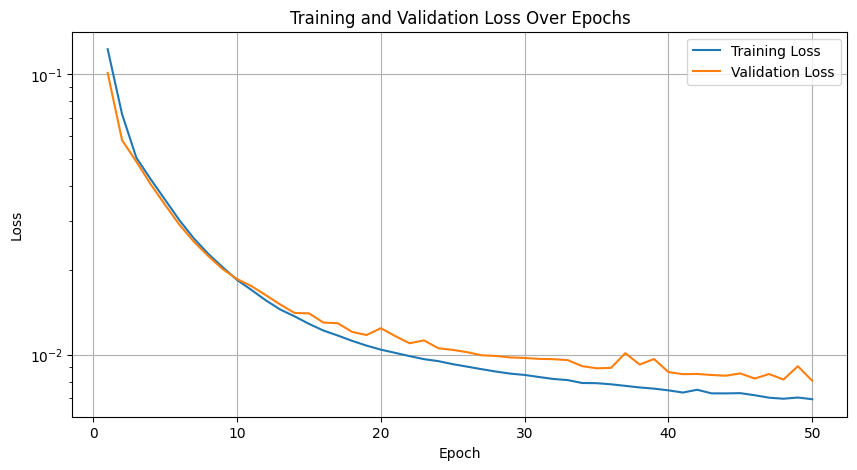

In [ ]:
# Create a plot of training and validation losses
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
ax.set_yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = loss_fn(y_pred, y_test_tensor).item()
    print(f"Test Loss: {test_loss}")

# Save the model
torch.save(model.state_dict(), 'model_11k.pth')

Test Loss: 0.2334563136100769


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1707])) that is different to the input size (torch.Size([1707, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
# Print true and predicted values
for true, pred in zip(y_test[:100], y_pred.tolist()[:100]):
    print(f"True: {true}, Predicted: {pred}")

True: 0.09501648334557618, Predicted: [0.12087370455265045]
True: 1.1702300156168265e-11, Predicted: [-0.010196041315793991]
True: 0.0, Predicted: [-0.0067215003073215485]
True: 4.720007476675832e-05, Predicted: [-0.003118019551038742]
True: 0.023287717772783965, Predicted: [0.03565071150660515]
True: 0.0, Predicted: [-0.051439907401800156]
True: 0.0, Predicted: [-0.018868248909711838]
True: 0.0, Predicted: [-0.00734793022274971]
True: 4.03199003735671e-11, Predicted: [-0.008567478507757187]
True: 3.821138289710384e-08, Predicted: [-0.007883157581090927]
True: 0.763437781905207, Predicted: [0.5751135349273682]
True: 0.0, Predicted: [-0.005150366574525833]
True: 0.5044446776319355, Predicted: [0.4770084619522095]
True: 7.440086685681769e-09, Predicted: [-0.033794548362493515]
True: 0.04272308665047889, Predicted: [0.11257430911064148]
True: 0.3059998462526766, Predicted: [0.10276058316230774]
True: 0.0, Predicted: [0.04548525810241699]
True: 0.08782566794397852, Predicted: [0.0241278521

# TORCH 2D Output (Our Metrics)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib

# Define the model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Output layer for 2D output
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

# Assuming 'inputs' and 'labels' are your data
# labels should be a list of lists with 2 elements each, for example: [[output1, output2], ...]

# Split the data into training, validation, and test sets
labels = [[s,m] for s,m in zip(success_labels, maneuver_labels)]
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Min-Max Scaling
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)
X_val = min_max_scaler.transform(X_val)
joblib.dump(min_max_scaler, 'scaler_minmax_ours.pkl')

# Convert arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = NeuralNetwork()

# Define the optimizer and loss function
learning_rate = 2e-4  # Adjusted learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()  # Mean Squared Error Loss for regression

# Training and validation loops
def train_loop(dataloader, model, loss_fn, optimizer):
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def val_loop(dataloader, model, loss_fn):
    total_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss = loss_fn(pred, y)
            total_loss += loss.item()

    return total_loss / len(dataloader)

# Training process
epochs = 1000
train_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    val_loss = val_loop(val_loader, model, loss_fn)
    print(f"Epoch {epoch+1}\n-------------------------------")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = loss_fn(y_pred, y_test_tensor).item()
    print(f"Test Loss: {test_loss}")

# Save the model
torch.save(model.state_dict(), 'model_ours.pth')

Epoch 1
-------------------------------
Training Loss: 0.1310
Validation Loss: 0.0940
Epoch 2
-------------------------------
Training Loss: 0.0849
Validation Loss: 0.0815
Epoch 3
-------------------------------
Training Loss: 0.0777
Validation Loss: 0.0761
Epoch 4
-------------------------------
Training Loss: 0.0733
Validation Loss: 0.0714
Epoch 5
-------------------------------
Training Loss: 0.0695
Validation Loss: 0.0682
Epoch 6
-------------------------------
Training Loss: 0.0663
Validation Loss: 0.0656
Epoch 7
-------------------------------
Training Loss: 0.0627
Validation Loss: 0.0633
Epoch 8
-------------------------------
Training Loss: 0.0594
Validation Loss: 0.0589
Epoch 9
-------------------------------
Training Loss: 0.0559
Validation Loss: 0.0575
Epoch 10
-------------------------------
Training Loss: 0.0531
Validation Loss: 0.0568
Epoch 11
-------------------------------
Training Loss: 0.0509
Validation Loss: 0.0505
Epoch 12
-------------------------------
Training Lo

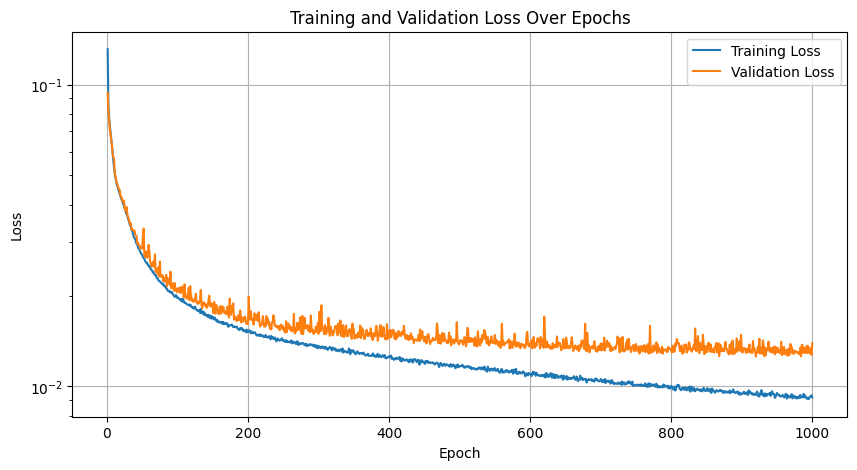

In [ ]:
# Create a plot of training and validation losses
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
ax.set_yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)

# Display the plot
# plt.show()
# Save the plot as an image (optional)
plt.savefig("loss_plot_ours.png")


In [ ]:
import pandas as pd

# Create a DataFrame to store epoch, training loss, and validation loss
data = {'Epoch': range(1, epochs + 1), 'Training Loss': train_losses, 'Validation Loss': val_losses}
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv("losses_ours.csv", index=False)


<Figure size 640x480 with 0 Axes>

In [ ]:
# Print true and predicted values
for true, pred in zip(y_test[:10], y_pred.tolist()[:10]):
    print(f"True: {true}, Predicted: {pred}")

True: [0.0032862815802978847, 0.0029840178365195813], Predicted: [0.06847857683897018, 0.0046387240290641785]
True: [0.0037801411749197335, 0.8626229080007829], Predicted: [0.01725202053785324, 0.6307054758071899]
True: [0.00014736244473630098, 0.9490254904107356], Predicted: [-0.006303668022155762, 0.7775164842605591]
True: [0.5789697879762071, 0.12382299591741197], Predicted: [0.5205562114715576, 0.3176575005054474]
True: [0.0001178619611508935, 0.7607133574354158], Predicted: [0.07530687004327774, 0.8853983879089355]
True: [3.5638337589401154e-06, 0.2891284826907754], Predicted: [-0.00021927803754806519, 0.28335705399513245]
True: [2.5735504510996002e-05, 0.09192884317012084], Predicted: [0.006238944828510284, 0.3101727366447449]
True: [0.9545577398973092, 0.42081027047964603], Predicted: [0.9250941872596741, 0.5119781494140625]
True: [0.0, 0.6805866481887891], Predicted: [-0.0025470927357673645, 0.6355421543121338]
True: [6.839057167939366e-07, 0.0012980712212860013], Predicted: [0

# TORCH 3D Output (Hou Quality Metrics)

In [ ]:
# Define the model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)  # Adjusted for 3D output
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

# Assuming 'inputs' and 'labels' are your data
# labels should be a list of lists with 3 elements each, for example: [[output1, output2, output3], ...]

# Split the data into training, validation, and test sets
labels = [[q[0], min(20,q[1]), min(5,q[2])] for q in quality] # cap the exceedingly large values
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Min-Max Scaling
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)
X_val = min_max_scaler.transform(X_val)
joblib.dump(min_max_scaler, 'scaler_minmax_hou.pkl')

# Standardization Scaling
# standard_scaler = StandardScaler()
# X_train = standard_scaler.fit_transform(X_train)
# X_test = standard_scaler.transform(X_test)
# X_val = standard_scaler.transform(X_val)
# joblib.dump(min_max_scaler, 'scaler_standard_hou.pkl')

# Convert arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = NeuralNetwork()

# Define the optimizer and loss function
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()  # Mean Squared Error Loss for regression

# Training and validation loops
def train_loop(dataloader, model, loss_fn, optimizer):
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def val_loop(dataloader, model, loss_fn):
    total_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss = loss_fn(pred, y)
            total_loss += loss.item()

    return total_loss / len(dataloader)

# Training process
epochs = 300
train_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    val_loss = val_loop(val_loader, model, loss_fn)
    print(f"Epoch {epoch+1}\n-------------------------------")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = loss_fn(y_pred, y_test_tensor).item()
    print(f"Test Loss: {test_loss}")

# Save the model
torch.save(model.state_dict(), 'model_hou.pth')

Epoch 1
-------------------------------
Training Loss: 0.8904
Validation Loss: 0.9302
Epoch 2
-------------------------------
Training Loss: 0.8357
Validation Loss: 0.9258
Epoch 3
-------------------------------
Training Loss: 0.8144
Validation Loss: 0.8895
Epoch 4
-------------------------------
Training Loss: 0.7805
Validation Loss: 0.8627
Epoch 5
-------------------------------
Training Loss: 0.7752
Validation Loss: 0.8525
Epoch 6
-------------------------------
Training Loss: 0.7558
Validation Loss: 0.8486
Epoch 7
-------------------------------
Training Loss: 0.7517
Validation Loss: 0.8447
Epoch 8
-------------------------------
Training Loss: 0.7483
Validation Loss: 0.8389
Epoch 9
-------------------------------
Training Loss: 0.7453
Validation Loss: 0.8353
Epoch 10
-------------------------------
Training Loss: 0.7418
Validation Loss: 0.8345
Epoch 11
-------------------------------
Training Loss: 0.7388
Validation Loss: 0.8281
Epoch 12
-------------------------------
Training Lo

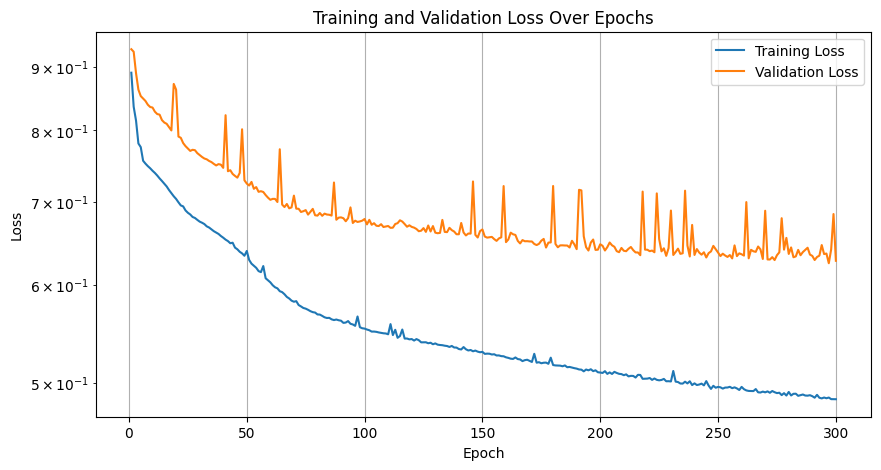

In [ ]:
# Create a plot of training and validation losses
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
ax.set_yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)

# Display the plot
# plt.show()
plt.savefig("loss_plot_hou.png")

In [ ]:

# Create a DataFrame to store epoch, training loss, and validation loss
data = {'Epoch': range(1, epochs + 1), 'Training Loss': train_losses, 'Validation Loss': val_losses}
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv("losses_hou.csv", index=False)

In [ ]:
# Print true and predicted values
for true, pred in zip(y_test[:100], y_pred.tolist()[:100]):
    print(f"True: {true}, Predicted: {pred}")

True: [1.0637158155441284, 0.0, 0.0], Predicted: [0.7594214677810669, 0.0005486607551574707, -0.06414743512868881]
True: [0.013681568205356598, 0.0, 0.0], Predicted: [0.05023910850286484, 0.12527771294116974, 0.2374332845211029]
True: [5.738589243264869e-05, 0.0, 0.0], Predicted: [0.07587772607803345, 0.39014172554016113, 1.05942702293396]
True: [0.14748062193393707, 0.0, 0.0], Predicted: [0.24927490949630737, 0.08212219178676605, -0.04458225518465042]
True: [0.38772258162498474, 0.0, 0.0], Predicted: [0.32027122378349304, 0.004027873277664185, 0.04922395199537277]
True: [0.4457491636276245, 0.0, 0.0], Predicted: [0.4339592754840851, 0.00956900417804718, 0.034002386033535004]
True: [0.6176474690437317, 0.0, 0.0], Predicted: [0.49725261330604553, 0.03187790513038635, -0.008779950439929962]
True: [4.9530585783941206e-06, 0.042345017194747925, 0.21050925552845], Predicted: [0.029035722836852074, 0.15117891132831573, 0.7989487051963806]
True: [0.12702248990535736, 0.0, 0.0], Predicted: [0.